# Template #1. Baseline modeling LGBMClassifier

Подготовка baseline модели должна отнимать минимум времени и она преследует цель вывода модели в продакшн.  
Цели baseline модели:  
1) получение нижних оценок метрик для понимания заинтересованных лиц какие результаты потенциально могут быть достигнуты. Своего рода Proof of concept;  
2) обнаружение недостатков в датасете;  
3) оценка важности признаков.  

In [39]:
# Import dependencies
from collections import Counter
from datetime import timedelta
from itertools import product
from pathlib import Path
from time import perf_counter
import joblib
import os
import sys
import warnings

from lightgbm import LGBMClassifier, plot_importance
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    brier_score_loss,
    confusion_matrix,
    f1_score,
    log_loss,
    make_scorer,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    precision_recall_fscore_support
)
from sklearn.model_selection import (
    cross_validate,
    GridSearchCV,
    StratifiedKFold, 
    train_test_split
)
from sklearn.pipeline import make_pipeline, Pipeline
import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import sklearn.preprocessing as pp

sys.path.append(os.path.join(Path.home(), 'model_tools'))
from tools_metrics import (
    aggregate_cv_metrics,
    get_bucket_stats,
    get_metrics,
    grid_search_best_scores,
    grid_search_scores,
    show_top_features
)
from tools_viz import (
    display_df,
    set_display, 
    set_seed
)

# Вывести инф-цию о библиотеках
print(f"Версия lightgbm: {lightgbm.__version__}")
print(f"Версия shap: {shap.__version__}")
print(f"Версия joblib: {joblib.__version__}")
print(f"Версия numpy: {np.__version__}")
print(f"Версия pandas: {pd.__version__}")

# Настройки
seed = 1234
set_seed(seed)
set_display()

# Константы
NUM_INNER_CV = 3
NUM_OUTER_CV = 5
KEY_METRIC_ALIAS = 'AuROC'
RANK_NAME = f"rank_test_{KEY_METRIC_ALIAS}"
SCORE_DICT = {
    'F1': 'f1',
    'AuPR': 'average_precision',
    'AuROC': 'roc_auc',
    'Brier loss': 'neg_brier_score',
    'Log loss': 'neg_log_loss',
}


Версия lightgbm: 4.6.0
Версия shap: 0.49.1
Версия joblib: 1.5.2
Версия numpy: 2.3.4
Версия pandas: 2.3.3


In [ ]:
# Константы и установки

THR_PCT_MISS = 40 # используем как процент для пустых столбцов
SEED = 1234

# Назначим aliasis для некоторых атрибутов для удобства
SUR = 'surname'
TARGET = 'target'

# Настройки
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# 1. Чтение данных

In [9]:
# Прочитаем данные
t1 = perf_counter()

data = pd.read_csv("../train.csv")
data.columns = data.columns.str.lower()

data = data.assign(ids=lambda x: x['id'].astype(str) + '-' + x['customerid'].astype(str))
ids='ids'

data = data.drop(columns={'id','customerid'})
data = data.rename(columns = {'exited':'target'})


print(data.info())

print(f"Task completed in: {timedelta(seconds=perf_counter()-t1)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   surname          165034 non-null  object 
 1   creditscore      165034 non-null  int64  
 2   geography        165034 non-null  object 
 3   gender           165034 non-null  object 
 4   age              165034 non-null  float64
 5   tenure           165034 non-null  int64  
 6   balance          165034 non-null  float64
 7   numofproducts    165034 non-null  int64  
 8   hascrcard        165034 non-null  float64
 9   isactivemember   165034 non-null  float64
 10  estimatedsalary  165034 non-null  float64
 11  target           165034 non-null  int64  
 12  ids              165034 non-null  object 
dtypes: float64(5), int64(4), object(4)
memory usage: 16.4+ MB
None
Task completed in: 0:00:00.277801


In [10]:
# Обозначим типы атрибутов: категориальные, числовые 
# и другие группы, если в дальнейшем для них потребуется
# своя предобработка

target = 'target'

# Определим категориальные признаки
# здесь важно не включить в список служебные признаки, например ID
# поэтому определим список исключений
cat_elim = [SUR, ids]
cat_fts = [ft for ft in data.select_dtypes(include=['bool', 'category', 'object']).columns \
           if ft not in cat_elim]

print(f"Кол-во категориальных атрибутов: {len(cat_fts)}")
print(f"Примеры категориальных атрибутов:\n {cat_fts[:10]}")

# Определим числовые признаки
num_elim = [TARGET, ids]
num_fts = [ft for ft in data.select_dtypes(include=['int', 'float']).columns \
           if ft not in num_elim]

print(f"\nКол-во числовых атрибутов: {len(num_fts)}")
print(f"Примеры числовых атрибутов:\n {num_fts[:10]}")

Кол-во категориальных атрибутов: 2
Примеры категориальных атрибутов:
 ['geography', 'gender']

Кол-во числовых атрибутов: 8
Примеры числовых атрибутов:
 ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary']


## Чек-лист для пункта Чтение данных
- [x] Данные загружены в DataFrame.  
- [x] Выделены группы атрибутов (чаще всего это категориальные и числовые).

# 2. Деление на train и test
Вариантов разделения на train и test несколько. Как правило, используют out-of-sample тестирование с использованием стратифицированного отбора классов.

In [11]:
# Определим train и test 

features = [*cat_fts, *num_fts]

X = data[features].copy()
y = data[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    shuffle=True,
    stratify=y,
    random_state=seed
)

print('For train dataset:')
print(f"Кол-во наблюдений в train: {len(X_train)}")
for key, val in dict(Counter(y_train)).items():
    print(f"Класс {key} - {val} - {val / len(y_train) * 100:.2f}%")

print('\nFor test dataset:')
print(f"Кол-во наблюдений в test: {len(X_test)}")
for key, val in dict(Counter(y_test)).items():
    print(f"Класс{key} - {val} - {val / len(y_test) * 100:.2f}%")

For train dataset:
Кол-во наблюдений в train: 132027
Класс 0 - 104090 - 78.84%
Класс 1 - 27937 - 21.16%

For test dataset:
Кол-во наблюдений в test: 33007
Класс0 - 26023 - 78.84%
Класс1 - 6984 - 21.16%


## Чек-лист для пункта Деление на train и test
- [x] Test по своей репрезентативности, сбалансированности и прочим характеристикам максимально похожа на реальные данные, которые потом будет получать на вход обученная модель.
- [x] Если в датасете присутствует один и тот же субъект в нескольких экземплярах, например, для Клиента 1 есть 2 записи: старая и новая, то при тестировании или кросс-валидации более новая запись находится в тестовом подмножестве.

# 3. Моделирование

## 4.1. Определение модели(ей)

#### Эта часть работает долго оставил только самые быстрые модели остальные закоментировал

In [12]:
# Определим модели, которые будем обучать
# При определении модели зададим 3 пункта:
# 1 - сам estimator, который рекомендуется выполнить в виде Pipeline
# 2 - сетку гиперпараметров для поиска оптимальных
# 3 - параметры модели, которые понадобятся при обучении


def init_lgbm(cat_fts=cat_fts, num_fts=num_fts):
    """LGBMClassifier без SimpleImputer"""
    preprocessor = ColumnTransformer(
        [
            ('cat_fts', 
             pp.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan),
             cat_fts),
            ('num_fts', 'passthrough', num_fts)
        ],
        remainder='drop'
    )

    clf = LGBMClassifier(
        objective='binary',
        random_state=seed,
        n_jobs=-1    
    )

    estimator = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])

    param_grid = {
        'classifier__n_estimators': [100, 250, 500],
        'classifier__max_depth': [3, 4, 5],
        'classifier__learning_rate': [0.05, 0.1, 0.2],
        'classifier__boosting_type': ['gbdt', 'dart']
    }

    cat_idx = list(range(0, len(cat_fts)))

    return {
        'estimator': estimator,
        'param_grid': param_grid,
        'fit_params': {'classifier__categorical_feature': cat_idx}
    }

from catboost import CatBoostClassifier

# def init_cb(cat_fts=cat_fts, num_fts=num_fts):
#     """CatBoostClassifier без обработки пропусков (CatBoost сам умеет работать с NaN и категориальными признаками)"""

#     preprocessor = ColumnTransformer(
#         [
#             ('cat_fts', 'passthrough', cat_fts),
#             ('num_fts', 'passthrough', num_fts)
#         ],
#         remainder='drop'
#     )

#     clf = CatBoostClassifier(
#         iterations=500,
#         learning_rate=0.1,
#         depth=6,
#         loss_function='Logloss',
#         random_seed=seed,
#         verbose=0
#     )

#     estimator = Pipeline([
#             ('preprocessor', preprocessor),
#             ('classifier', clf)
#         ])

#     param_grid = {
#     'classifier__depth': [4, 6, 8],
#     'classifier__learning_rate': [0.05, 0.1, 0.2],
#     'classifier__iterations': [250, 500, 1000]
#     }

#     cat_idx = [i for i in range(len(cat_fts))]

#     return {
#         'estimator': estimator,
#         'param_grid': param_grid,
#         'fit_params': {'classifier__cat_features': cat_idx}
#     }

# from sklearn.ensemble import HistGradientBoostingClassifier

# def init_hgb(cat_fts=cat_fts, num_fts=num_fts):
#     """HistGradientBoostingClassifier без SimpleImputer"""
    
#     preprocessor = ColumnTransformer(
#         [
#             ('cat_fts', pp.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_fts),
#             ('num_fts', 'passthrough', num_fts)
#         ],
#         remainder='drop'
#     )

#     clf = HistGradientBoostingClassifier(
#         max_iter=500,
#         learning_rate=0.1,
#         max_depth=None,
#         random_state=seed
#     )

#     estimator = Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', clf)
#     ])

#     param_grid = {
#         'classifier__max_iter': [250, 500, 1000],
#         'classifier__learning_rate': [0.05, 0.1, 0.2],
#         'classifier__max_depth': [3, 5, 8]
#     }

#     return {
#         'estimator': estimator,
#         'param_grid': param_grid,
#         'fit_params': None
#     }

def init_lr(cat_fts=cat_fts, num_fts=num_fts):
    """Logistic Regression без SimpleImputer"""
    preprocessor = ColumnTransformer(
        [
            ('cat_fts', 
             pp.OneHotEncoder(drop='first', handle_unknown='ignore'),
             cat_fts),
            ('num_fts', 
             make_pipeline(
                 pp.FunctionTransformer(func=np.log1p), 
                 pp.StandardScaler()
             ), 
             num_fts)
        ],
        remainder='drop'
    )

    clf = LogisticRegression(random_state=seed, n_jobs=-1)

    estimator = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])

    # Подбор гиперпараметров
    classifier__penalty = ['l1', 'l2', 'none']
    classifier__C = np.logspace(-2, 1, 4)
    classifier__solver = ['lbfgs', 'liblinear', 'newton-cg']
    
    param_grid = [
        {'classifier__penalty': [penalty], 'classifier__C': [C], 'classifier__solver': [solver]} 
        for penalty, C, solver in product(classifier__penalty, classifier__C, classifier__solver) 
        if not(
            (solver in ['lbfgs', 'newton-cg'] and penalty == 'l1')
            or (solver == 'liblinear' and penalty == 'none')
        )
    ]

    return {
        'estimator': estimator,
        'param_grid': param_grid,
        'fit_params': None
    }

def init_rf(cat_fts=cat_fts, num_fts=num_fts):
    """RandomForestClassifier без SimpleImputer"""
    preprocessor = ColumnTransformer(
        [
            ('cat_fts', 
             pp.OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
             cat_fts),
            ('num_fts', 'passthrough', num_fts)
        ],
        remainder='drop'
    )

    clf = RandomForestClassifier(random_state=seed, n_jobs=-1)

    estimator = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])

    param_grid = {
        'classifier__n_estimators': [100, 250], 
        'classifier__max_depth': [5, 8],
    }

    return {
        'estimator': estimator,
        'param_grid': param_grid,
        'fit_params': None
    }

## 4.2. Обучение модели(ей)

In [13]:
# Кросс-валидацию уже можно отнести за рамки построения baseline модели, 
# однако с другой стороны при её наличии не требуется 
# выбирать конкретные гиперпараметры.


def training_model_with_cv(X, y, 
                           model,
                           scoring=SCORE_DICT,
                           num_cv=NUM_OUTER_CV):
    """Tuning hyperparameters."""

    model_cv = GridSearchCV(
        estimator=model['estimator'],
        param_grid=model['param_grid'],
        scoring=scoring,
        cv=StratifiedKFold(n_splits=num_cv, shuffle=True, random_state=seed),
        refit=KEY_METRIC_ALIAS,  # refit estimator using the best found parameters on the whole dataset
        n_jobs=-1
    )

    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=UserWarning)
        if model['fit_params'] is not None:
            model_cv.fit(X, y, **model['fit_params'])
        else:
            model_cv.fit(X, y)

    return model_cv


In [14]:
# Сделаем GridSearchCV с несколькими моделями
t1 = perf_counter()

trained_models = {}
models = [
    init_lgbm(),
    init_rf(), 
    init_lr()
]

cv_metrics_list = []

for model in models:
    model_name = model['estimator']['classifier'].__class__.__name__
    
    # Тренировка модели с кросс-валидацией
    trained_model = training_model_with_cv(
        X_train, y_train,
        model,
        num_cv=NUM_OUTER_CV
    )
    trained_models[model_name] = trained_model
    
    # Получаем метрики
    metrics_df = grid_search_best_scores(trained_model, model_name)
    cv_metrics_list.append(metrics_df)

# Объединяем все метрики в один DataFrame
cv_metrics = pd.concat(cv_metrics_list, ignore_index=True)

display_df(cv_metrics, titles=['Train CV metrics'])

print(f"Task completed in: {timedelta(seconds=perf_counter()-t1)}")

[LightGBM] [Info] Number of positive: 22349, number of negative: 83272
[LightGBM] [Info] Number of positive: 22350, number of negative: 83272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 105621, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211596 -> initscore=-1.315331
[LightGBM] [Info] Start training from score -1.315331
[LightGBM] [Info] Number of positive: 22350, number of negative: 83272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/dinislamvaliev/offer/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
40 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/dinislamvaliev/offer/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dinislamvaliev/offer/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dinislamvaliev/offer/lib/python3.12/site-packages/sklearn/pip

Train CV metrics 
 
 
 
 Model 
 F1 
 AuPR 
 AuROC 
 Brier loss 
 Log loss 
 
 
 
 
 0 
 LGBMClassifier 
 0.63207381 +/- 0.00268802 
 0.73103410 +/- 0.00247345 
 0.88989698 +/- 0.00154007 
 -0.09788197 +/- 0.00047397 
 -0.31921085 +/- 0.00151805 
 
 
 1 
 RandomForestClassifier 
 0.59629972 +/- 0.00193174 
 0.71622310 +/- 0.00446445 
 0.88552967 +/- 0.00230585 
 -0.10217187 +/- 0.00057461 
 -0.33382555 +/- 0.00186167 
 
 
 2 
 LogisticRegression 
 0.51886449 +/- 0.00472554 
 0.61589993 +/- 0.00270741 
 0.82623931 +/- 0.00147515 
 -0.11897947 +/- 0.00038828 
 -0.38698573 +/- 0.00122468

Task completed in: 0:23:04.971701


In [ ]:
# # Если необходимо сделать GridSearchCV с одной моделью
# t1 = perf_counter()

# trained_model = training_model_with_cv(
#     X_train, y_train, 
#     init_rf(), 
#     num_cv=NUM_OUTER_CV
# )

# cv_metrics = grid_search_scores(trained_model.cv_results_)
# display_df(cv_metrics.head(15), titles=['Tuning hyperparams'])

# print(f"Task completed in: {timedelta(seconds=perf_counter()-t1)}")

In [15]:
# Покажем различные метрики для train

trained_model = trained_models['LGBMClassifier']
y_train_pred = trained_model.predict(X_train)
y_train_pred_pbs = trained_model.predict_proba(X_train)[:, 1]
y_true = y_train.to_numpy().ravel()  # превращаем DataFrame/Series → numpy

display_df(
    get_metrics(y_true, y_train_pred, y_train_pred_pbs), 
    titles=['Train metrics']
)

display_df(
    get_bucket_stats(y_true, y_train_pred, y_train_pred_pbs),
    titles=['Train bucket metrics']
)

/Users/dinislamvaliev/offer/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/dinislamvaliev/offer/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train metrics 
 
 
 
 Metric 
 Value 
 
 
 
 
 0 
 AuPR 
 0.73752916 
 
 
 1 
 AuROC 
 0.89248129 
 
 
 2 
 Balanced Accuracy 
 0.75127814 
 
 
 3 
 Brier loss 
 0.09680494 
 
 
 4 
 F1 
 0.63672118 
 
 
 5 
 Log loss 
 0.31588911

Train bucket metrics 
 
 
 
 Интервал скора 
 Класс 0 
 Класс 1 
 threshold 
 precision 
 recall 
 f1 
 tn 
 fp 
 fn 
 tp 
 pos_lr 
 neg_lr 
 gain 
 
 
 
 
 0 
 (-0.001, 0.05] 
 46968 
 919 
 0.05 
 0.32110768 
 0.96710456 
 0.48213282 
 46968.0 
 57122.0 
 919.0 
 27018.0 
 1.76229672 
 0.07290254 
 0.0 
 
 
 1 
 (0.05, 0.1] 
 18661 
 1343 
 0.10 
 0.40032119 
 0.91903211 
 0.55770964 
 65629.0 
 38461.0 
 2262.0 
 25675.0 
 2.48724818 
 0.12841805 
 0.0 
 
 
 2 
 (0.1, 0.15] 
 10436 
 1381 
 0.15 
 0.46434374 
 0.86959946 
 0.60541268 
 76065.0 
 28025.0 
 3643.0 
 24294.0 
 3.22985218 
 0.17844465 
 0.0 
 
 
 3 
 (0.15, 0.2] 
 7081 
 1418 
 0.20 
 0.52204473 
 0.81884240 
 0.63759633 
 83146.0 
 20944.0 
 5061.0 
 22876.0 
 4.06958102 
 0.22679017 
 0.0 
 
 
 4 
 (0.2, 0.25] 
 4956 
 1343 
 0.25 
 0.57389195 
 0.77076995 
 0.65791805 
 88102.0 
 15988.0 
 6404.0 
 21533.0 
 5.01810381 
 0.27082877 
 0.0 
 
 
 5 
 (0.25, 0.3] 
 3404 
 1236 
 0.30 
 0.61728658 
 0.72652754 
 0.66746687 
 91506.0 
 12584.0 
 7640.0 
 20297.0 
 6.00955595 
 0.31108067 
 0.0 
 
 
 6 
 (0.3, 0.35] 
 2827 
 1325 
 0.35 
 0.66037802 
 0.67909940 
 0.66960788 
 94333.0 
 9757.0 
 8965.0 
 18972.0 
 7.24479418 
 0.35409182 
 0.0 
 
 
 7 
 (0.35, 0.4] 
 1983 
 1218 
 0.40 
 0.69547164 
 0.63550131 
 0.66413542 
 96316.0 
 7774.0 
 10183.0 
 17754.0 
 8.50904695 
 0.39391865 
 0.0 
 
 
 8 
 (0.4, 0.45] 
 1551 
 1188 
 0.45 
 0.72692966 
 0.59297706 
 0.65315617 
 97867.0 
 6223.0 
 11371.0 
 16566.0 
 9.91852510 
 0.43290403 
 0.0 
 
 
 9 
 (0.45, 0.5] 
 1230 
 1186 
 0.50 
 0.75492073 
 0.55052439 
 0.63672118 
 99097.0 
 4993.0 
 12557.0 
 15380.0 
 11.47688448 
 0.47212242 
 0.0 
 
 
 10 
 (0.5, 0.55] 
 1098 
 1290 
 0.55 
 0.78343064 
 0.50434907 
 0.61364923 
 100195.0 
 3895.0 
 13847.0 
 14090.0 
 13.47822717 
 0.51491896 
 0.0 
 
 
 11 
 (0.55, 0.6] 
 924 
 1258 
 0.60 
 0.81199772 
 0.45931918 
 0.58673983 
 101119.0 
 2971.0 
 15105.0 
 12832.0 
 16.09240448 
 0.55656668 
 0.0 
 
 
 12 
 (0.6, 0.65] 
 773 
 1242 
 0.65 
 0.84058602 
 0.41486201 
 0.55554224 
 101892.0 
 2198.0 
 16347.0 
 11590.0 
 19.64649077 
 0.59776050 
 0.0 
 
 
 13 
 (0.65, 0.7] 
 640 
 1525 
 0.70 
 0.86595543 
 0.36027490 
 0.50884732 
 102532.0 
 1558.0 
 17872.0 
 10065.0 
 24.06997098 
 0.64944588 
 0.0 
 
 
 14 
 (0.7, 0.75] 
 475 
 1356 
 0.75 
 0.88939951 
 0.31173712 
 0.46166079 
 103007.0 
 1083.0 
 19228.0 
 8709.0 
 29.96188099 
 0.69549917 
 0.0 
 
 
 15 
 (0.75, 0.8] 
 359 
 1449 
 0.80 
 0.90931864 
 0.25987042 
 0.40422037 
 103366.0 
 724.0 
 20677.0 
 7260.0 
 37.36175732 
 0.74531362 
 0.0 
 
 
 16 
 (0.8, 0.85] 
 300 
 1715 
 0.85 
 0.92896633 
 0.19848230 
 0.32708075 
 103666.0 
 424.0 
 22392.0 
 5545.0 
 48.72646828 
 0.80479595 
 0.0 
 
 
 17 
 (0.85, 0.9] 
 255 
 2162 
 0.90 
 0.95242117 
 0.12109389 
 0.21486868 
 103921.0 
 169.0 
 24554.0 
 3383.0 
 74.58380468 
 0.88033542 
 0.0 
 
 
 18 
 (0.9, 0.95] 
 148 
 2543 
 0.95 
 0.97560976 
 0.03006765 
 0.05833738 
 104069.0 
 21.0 
 27097.0 
 840.0 
 149.03532949 
 0.97012807 
 0.0 
 
 
 19 
 (0.95, 1.0] 
 21 
 840 
 1.00 
 0.00000000 
 0.00000000 
 0.00000000 
 104090.0 
 0.0 
 27937.0 
 0.0 
 NaN 
 1.00000000 
 0.0 
 
 
 20 
 Общий итог 
 104090 
 27937 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN

## Чек-лист для пункта Обучение модели
- [x] Получены различные метрики для train.
- [x] Среди метрик выбрана основная на основе которой в дальнейшем будет выбираться модель-победитель.

# 4. Интерпретация модели

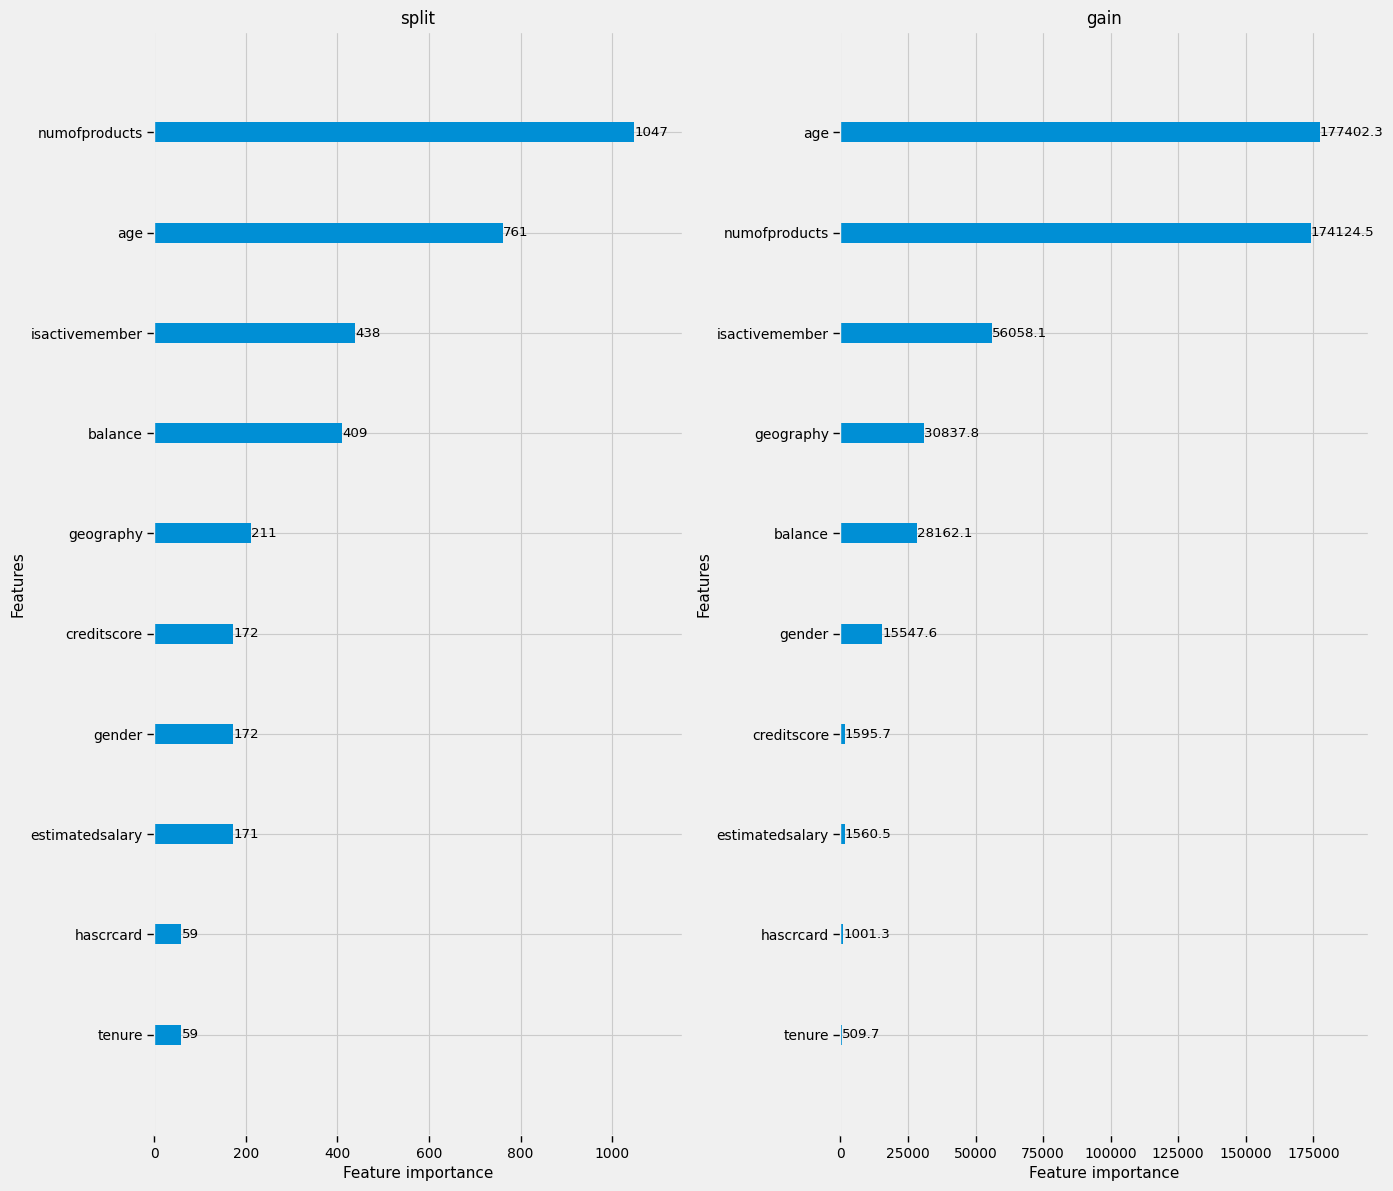

In [16]:
# Отобразим топ-атрибуты с точки зрения feature_importance
show_top_features(trained_model.best_estimator_, n_top=10, figsize=(14, 12))

/Users/dinislamvaliev/offer/lib/python3.12/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


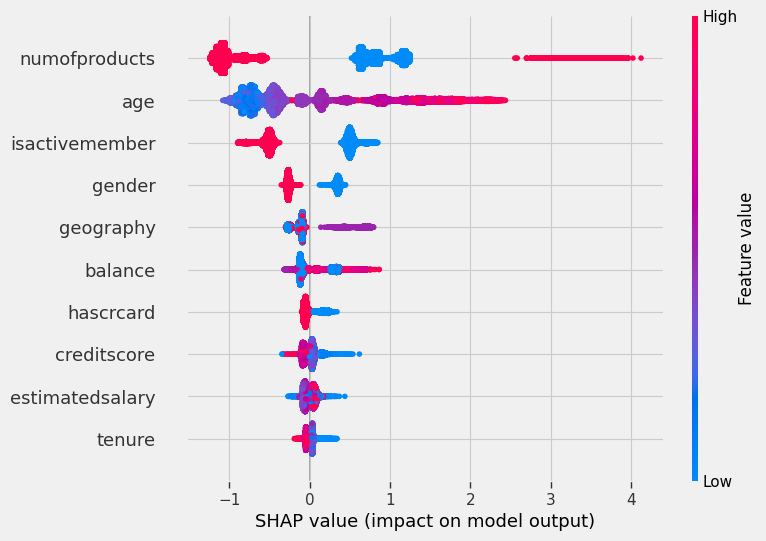

Task completed in: 0:00:05.582126


In [17]:
# Выведем важность атрибутов с т.зр. SHAP
# При этом будем использовать X_test
# Однако под вопросом какую часть датасета лучше использовать
t1 = perf_counter()

explainer = shap.TreeExplainer(trained_model.best_estimator_['classifier'])
preproc = trained_model.best_estimator_['preprocessor']
columns = [*trained_model.best_estimator_['preprocessor'].transformers_[0][2],
           *trained_model.best_estimator_['preprocessor'].transformers_[1][2]]
X_display = pd.DataFrame(preproc.transform(X_test), columns=columns)
shap_values = explainer.shap_values(X_display)
shap.summary_plot(shap_values, X_display)

print(f"Task completed in: {timedelta(seconds=perf_counter()-t1)}")

In [21]:
type(shap_values)
len(shap_values) if isinstance(shap_values, list) else 'not a list'

'not a list'

SHAP атрибутов:
['numofproducts' 'age' 'isactivemember' 'gender' 'geography' 'balance'
 'hascrcard' 'creditscore' 'estimatedsalary' 'tenure']


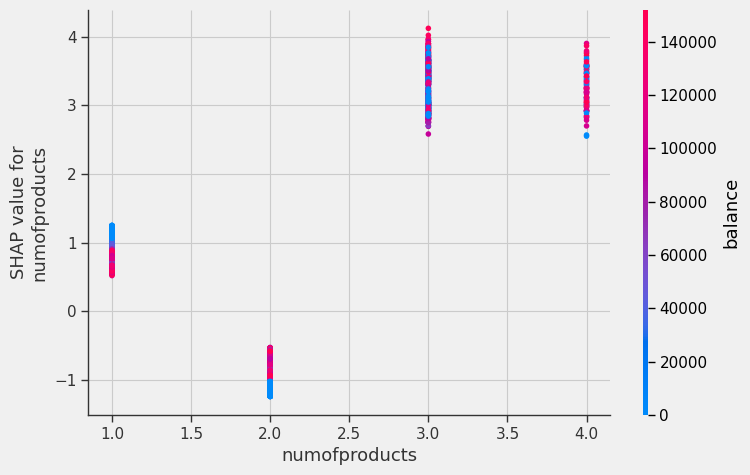

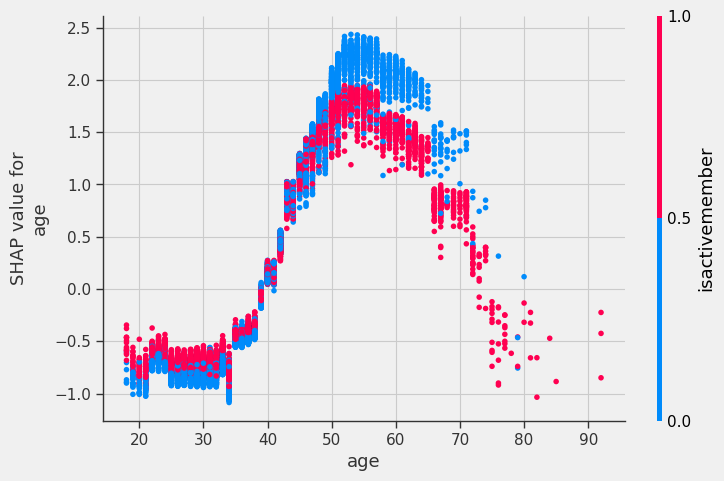

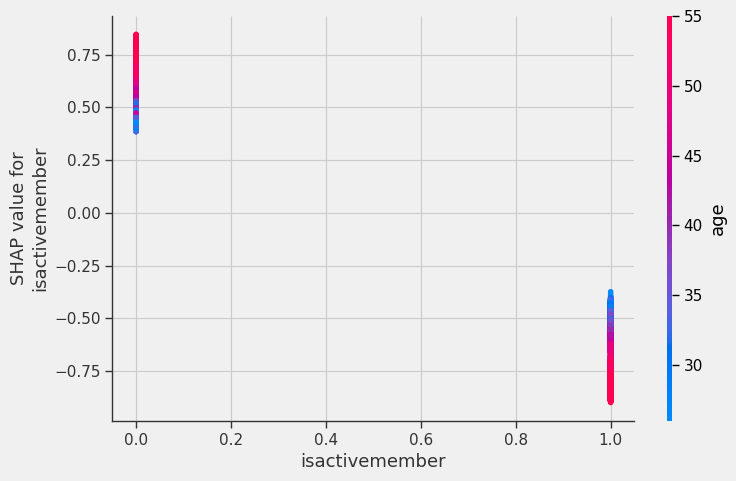

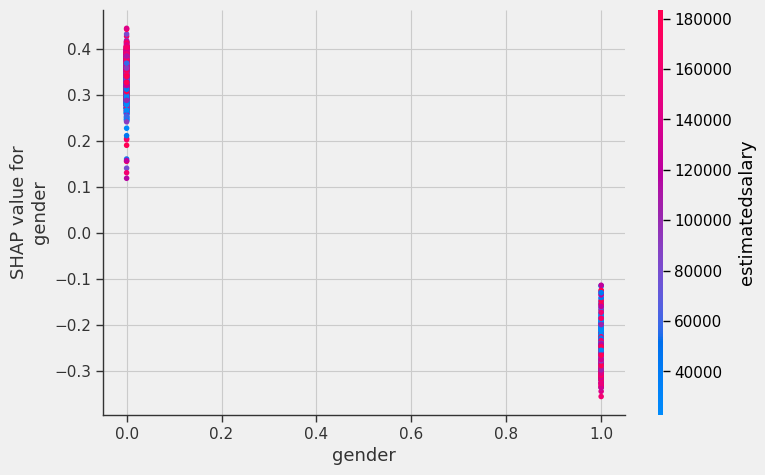

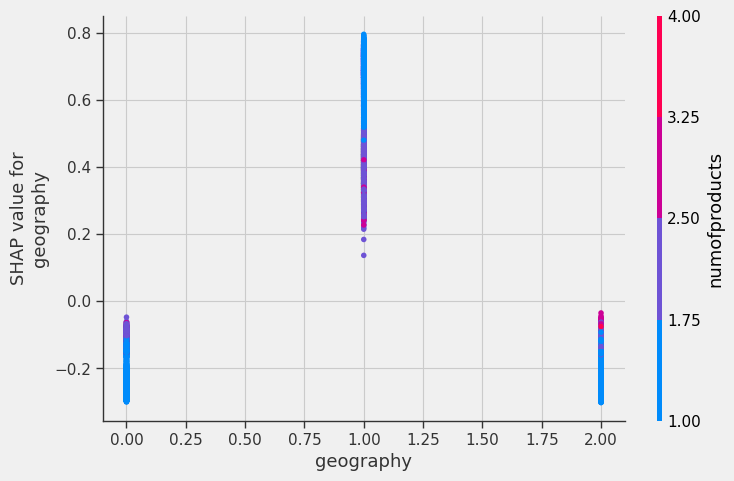

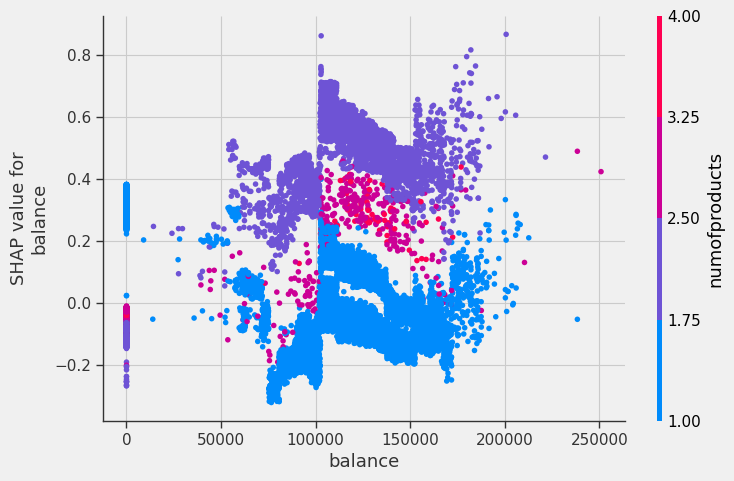

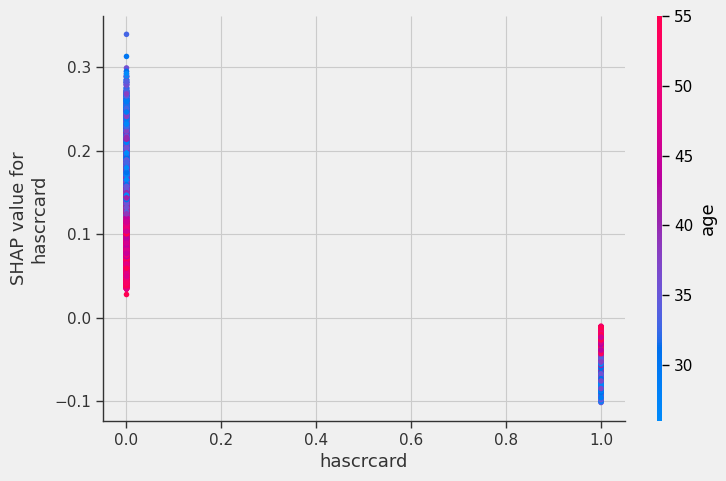

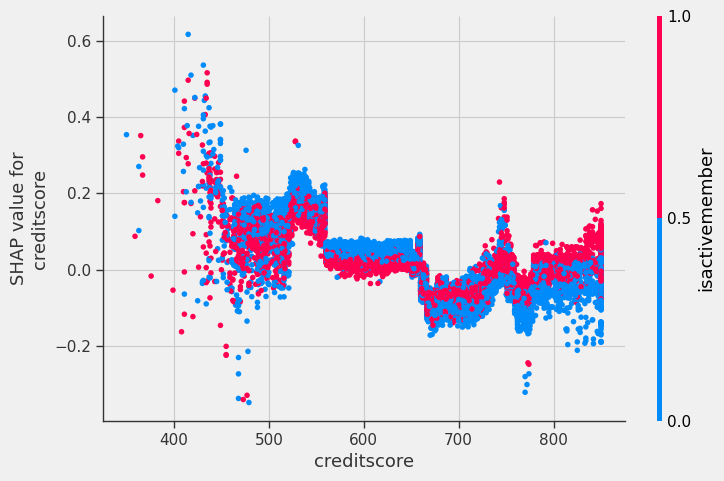

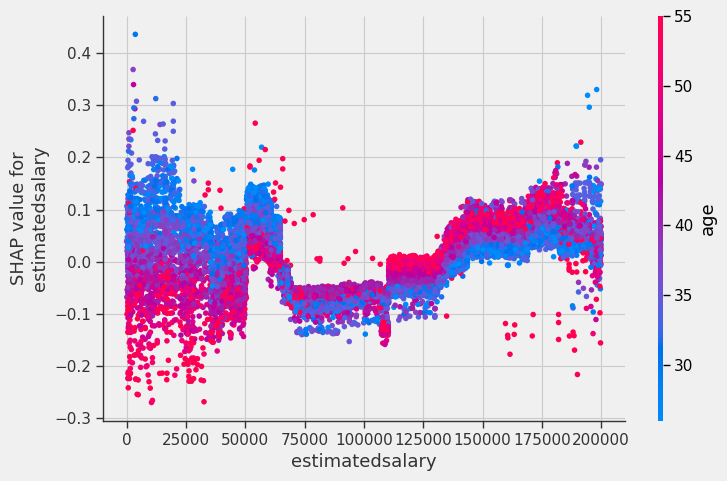

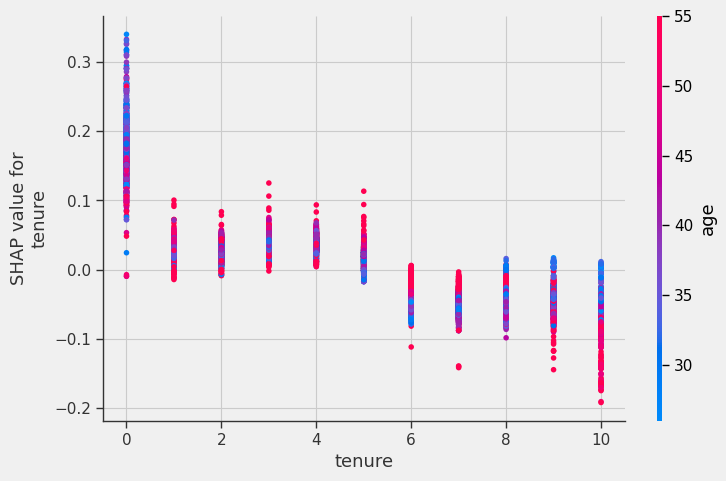

In [24]:
# Выведем dependency_plot для всех атрибутов
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_sum = np.abs(shap_values[1]).mean(0)
else:
    shap_sum = np.abs(shap_values).mean(0)

importance_df = pd.DataFrame({
    'feature': X_display.columns,
    'shap_importance': shap_sum
}).sort_values('shap_importance', ascending=False)

imp_fts = importance_df['feature'].values
print(f"SHAP атрибутов:\n{imp_fts}")

for name in imp_fts:
    shap.dependence_plot(name, shap_values[1] if isinstance(shap_values, list) else shap_values, X_display)

## Чек-лист для пункта Интерпретация модели
- [x] Определена важность атрибутов.
- [x] ТОП важных атрибутов логичен с точки зрения бизнеса и может быть интепретирован бизнесом.
- [x] Среди ТОП атрибутов нет таких, которые создают "утечку" информацию и не должны быть использованы в качестве атрибутов.

# 5. Тестирование модели

In [25]:
# Покажем метрики для test
y_test_pred = trained_model.predict(X_test)
y_test_pred_pbs = trained_model.predict_proba(X_test)[:, 1]
y_true = y_test.to_numpy().ravel()  # превращаем DataFrame/Series → numpy


display_df(
    get_metrics(y_true, y_test_pred, y_test_pred_pbs), 
    titles=['Test metrics']
)

display_df(
    get_bucket_stats(y_true, y_test_pred, y_test_pred_pbs),
    titles=['Test bucket metrics']
)

/Users/dinislamvaliev/offer/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/dinislamvaliev/offer/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Test metrics 
 
 
 
 Metric 
 Value 
 
 
 
 
 0 
 AuPR 
 0.72562362 
 
 
 1 
 AuROC 
 0.88811067 
 
 
 2 
 Balanced Accuracy 
 0.74609493 
 
 
 3 
 Brier loss 
 0.09870853 
 
 
 4 
 F1 
 0.62837163 
 
 
 5 
 Log loss 
 0.32165548

Test bucket metrics 
 
 
 
 Интервал скора 
 Класс 0 
 Класс 1 
 threshold 
 precision 
 recall 
 f1 
 tn 
 fp 
 fn 
 tp 
 pos_lr 
 neg_lr 
 gain 
 
 
 
 
 0 
 (-0.001, 0.05] 
 11725 
 249 
 0.05 
 0.32021110 
 0.96434708 
 0.48077953 
 11725.0 
 14298.0 
 249.0 
 6735.0 
 1.75515485 
 0.07912972 
 0.0 
 
 
 1 
 (0.05, 0.1] 
 4615 
 327 
 0.10 
 0.39823504 
 0.91752577 
 0.55540628 
 16340.0 
 9683.0 
 576.0 
 6408.0 
 2.46584459 
 0.13134803 
 0.0 
 
 
 2 
 (0.1, 0.15] 
 2575 
 382 
 0.15 
 0.45880920 
 0.86282932 
 0.59906551 
 18915.0 
 7108.0 
 958.0 
 6026.0 
 3.15889245 
 0.18871755 
 0.0 
 
 
 3 
 (0.15, 0.2] 
 1815 
 348 
 0.20 
 0.51754626 
 0.81300115 
 0.63247006 
 20730.0 
 5293.0 
 1306.0 
 5678.0 
 3.99711483 
 0.23474535 
 0.0 
 
 
 4 
 (0.2, 0.25] 
 1268 
 340 
 0.25 
 0.57011642 
 0.76431844 
 0.65308619 
 21998.0 
 4025.0 
 1646.0 
 5338.0 
 4.94157983 
 0.27880449 
 0.0 
 
 
 5 
 (0.25, 0.3] 
 854 
 320 
 0.30 
 0.61277323 
 0.71849943 
 0.66143808 
 22852.0 
 3171.0 
 1966.0 
 5018.0 
 5.89640826 
 0.32056229 
 0.0 
 
 
 6 
 (0.3, 0.35] 
 714 
 351 
 0.35 
 0.65510949 
 0.66824170 
 0.66161043 
 23566.0 
 2457.0 
 2317.0 
 4667.0 
 7.07759611 
 0.36634755 
 0.0 
 
 
 7 
 (0.35, 0.4] 
 492 
 311 
 0.40 
 0.68913147 
 0.62371134 
 0.65479143 
 24058.0 
 1965.0 
 2628.0 
 4356.0 
 8.25996957 
 0.40702302 
 0.0 
 
 
 8 
 (0.4, 0.45] 
 402 
 283 
 0.45 
 0.72267566 
 0.58319015 
 0.64548336 
 24460.0 
 1563.0 
 2911.0 
 4073.0 
 9.70976151 
 0.44344410 
 0.0 
 
 
 9 
 (0.45, 0.5] 
 309 
 299 
 0.50 
 0.75059666 
 0.54037801 
 0.62837163 
 24769.0 
 1254.0 
 3210.0 
 3774.0 
 11.21392095 
 0.48289164 
 0.0 
 
 
 10 
 (0.5, 0.55] 
 264 
 327 
 0.55 
 0.77687627 
 0.49355670 
 0.60362490 
 25033.0 
 990.0 
 3537.0 
 3447.0 
 12.97356165 
 0.52647202 
 0.0 
 
 
 11 
 (0.55, 0.6] 
 220 
 284 
 0.60 
 0.80422070 
 0.45289233 
 0.57946322 
 25253.0 
 770.0 
 3821.0 
 3163.0 
 15.30599608 
 0.56378977 
 0.0 
 
 
 12 
 (0.6, 0.65] 
 181 
 300 
 0.65 
 0.82937428 
 0.40993700 
 0.54867765 
 25434.0 
 589.0 
 4121.0 
 2863.0 
 18.11169868 
 0.60372767 
 0.0 
 
 
 13 
 (0.65, 0.7] 
 192 
 385 
 0.70 
 0.86191304 
 0.35481100 
 0.50268790 
 25626.0 
 397.0 
 4506.0 
 2478.0 
 23.25754802 
 0.65518432 
 0.0 
 
 
 14 
 (0.7, 0.75] 
 101 
 329 
 0.75 
 0.87893661 
 0.30770332 
 0.45582777 
 25727.0 
 296.0 
 4835.0 
 2149.0 
 27.05190387 
 0.70026184 
 0.0 
 
 
 15 
 (0.75, 0.8] 
 87 
 348 
 0.80 
 0.89601990 
 0.25787514 
 0.40048922 
 25814.0 
 209.0 
 5183.0 
 1801.0 
 32.10853996 
 0.74813338 
 0.0 
 
 
 16 
 (0.8, 0.85] 
 85 
 452 
 0.85 
 0.91581806 
 0.19315578 
 0.31902566 
 25899.0 
 124.0 
 5635.0 
 1349.0 
 40.53623374 
 0.81070725 
 0.0 
 
 
 17 
 (0.85, 0.9] 
 72 
 495 
 0.90 
 0.94260486 
 0.12227950 
 0.21647655 
 25971.0 
 52.0 
 6130.0 
 854.0 
 61.19383316 
 0.87947791 
 0.0 
 
 
 18 
 (0.9, 0.95] 
 41 
 628 
 0.95 
 0.95358650 
 0.03235968 
 0.06259521 
 26012.0 
 11.0 
 6758.0 
 226.0 
 76.55417578 
 0.96804952 
 0.0 
 
 
 19 
 (0.95, 1.0] 
 11 
 226 
 1.00 
 0.00000000 
 0.00000000 
 0.00000000 
 26023.0 
 0.0 
 6984.0 
 0.0 
 NaN 
 1.00000000 
 0.0 
 
 
 20 
 Общий итог 
 26023 
 6984 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN

## Чек-лист для пункта Тестирование модели
- [x] Получены различные метрики для test.
- [x] Отсутствуют явления переобучения модели.

# 6. Сохранение модели

In [27]:
# Save model
model_name = 'LGBMClf_cv_v0.pickle'
# joblib.dump(trained_model, os.path.join(PATH_MODEL, model_name))
# joblib.dump(trained_model.best_estimator_, os.path.join(PATH_MODEL, model_name))

# Upload model
# trained_model = joblib.load(os.path.join(PATH_MODEL, model_name))

## Чек-лист для пункта Сохранение модели
- [x] Модель сохранена в одном из популярных форматах, который может быть использован для дальнейшей продуктивизации модели.